In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from time import strptime
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold, cross_val_predict,GridSearchCV
from sklearn.metrics import matthews_corrcoef, accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("bank_full.csv", sep = ";")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
#change month to numeric
data['month'] = [strptime(str(x), '%b').tm_mon for x in data['month']]

#change all object data type to categorical
list_str_obj_cols = data.columns[data.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    data[str_obj_col] = data[str_obj_col].astype("category")

#encode all categorical data
df_encoded = pd.get_dummies(data, columns=['job', 'marital', 'education', 'default', 
                                           'housing', 'loan', 'contact', 'poutcome'],)

#standardize all numeric data
data_numeric = data[["age", "balance", "day", "duration", "campaign", "pdays", "previous", "month"]]
 
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(data_numeric.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ["age", "balance", "day", "duration", "campaign", "pdays", "previous", "month"])
 
#combine both datasets
df_encoded.update(df_scaled)

#change class label to 0 and 1
df_encoded.y = pd.Categorical(df_encoded.y).codes
newdata = df_encoded

In [5]:
pd.set_option('display.max_columns', None)
newdata

,age,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,-0.475354,0.011016,-0.569351,-0.411453,-0.251940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.475354,-0.416127,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.475354,-0.707361,-0.569351,-0.411453,-0.251940,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.475354,-0.645231,-0.569351,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.475354,-0.233620,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.947747,-0.176460,0.143418,2.016333,2.791329,0.076230,-0.411453,-0.251940,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45207,2.831227,0.120447,0.143418,2.016333,0.768224,-0.246560,-0.411453,-0.251940,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45208,2.925401,1.429593,0.143418,2.016333,3.373797,0.721811,1.436189,1.050473,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
45209,1.512791,-0.228024,0.143418,2.016333,0.970146,0.399020,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1


In [6]:
X = newdata.drop(["y"], axis=1)
y = newdata["y"]

In [7]:
newdata

,age,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,-0.475354,0.011016,-0.569351,-0.411453,-0.251940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.475354,-0.416127,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.475354,-0.707361,-0.569351,-0.411453,-0.251940,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.475354,-0.645231,-0.569351,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.475354,-0.233620,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.947747,-0.176460,0.143418,2.016333,2.791329,0.076230,-0.411453,-0.251940,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45207,2.831227,0.120447,0.143418,2.016333,0.768224,-0.246560,-0.411453,-0.251940,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45208,2.925401,1.429593,0.143418,2.016333,3.373797,0.721811,1.436189,1.050473,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
45209,1.512791,-0.228024,0.143418,2.016333,0.970146,0.399020,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1


In [8]:
#used for parameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .8)

In [9]:
X_train.shape

(36168, 40)

In [10]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores_train = []
mcc_scores_test = []
accuracy_scores_train = []
accuracy_scores_test = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Using Random Forest classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    
    # Predict on training data
    y_pred_train = clf.predict(X_train)
    mcc_train = matthews_corrcoef(y_train, y_pred_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    mcc_scores_train.append(mcc_train)
    accuracy_scores_train.append(acc_train)
    
    # Predict on testing data
    y_pred_test = clf.predict(X_test)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    mcc_scores_test.append(mcc_test)
    accuracy_scores_test.append(acc_test)

    # Print MCC and accuracy for this fold
    print(f"Fold {fold_num} - Train MCC: {mcc_train:.4f}, Test MCC: {mcc_test:.4f}, Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}")

# Compute average MCC and accuracy across all folds
average_mcc_train = sum(mcc_scores_train) / len(mcc_scores_train)
average_mcc_test = sum(mcc_scores_test) / len(mcc_scores_test)
average_acc_train = sum(accuracy_scores_train) / len(accuracy_scores_train)
average_acc_test = sum(accuracy_scores_test) / len(accuracy_scores_test)

print(f"\nAverage Train Matthews Correlation Coefficient over 5-folds: {average_mcc_train:.4f}")
print(f"Average Test Matthews Correlation Coefficient over 5-folds: {average_mcc_test:.4f}")
print(f"Average Train Accuracy over 5-folds: {average_acc_train:.4f}")
print(f"Average Test Accuracy over 5-folds: {average_acc_test:.4f}")


Fold 1 - Train MCC: 1.0000, Test MCC: 0.4225, Train Accuracy: 1.0000, Test Accuracy: 0.8766
Fold 2 - Train MCC: 1.0000, Test MCC: 0.3935, Train Accuracy: 1.0000, Test Accuracy: 0.8749
Fold 3 - Train MCC: 1.0000, Test MCC: 0.4019, Train Accuracy: 1.0000, Test Accuracy: 0.8724
Fold 4 - Train MCC: 1.0000, Test MCC: 0.3842, Train Accuracy: 1.0000, Test Accuracy: 0.8731
Fold 5 - Train MCC: 1.0000, Test MCC: 0.4024, Train Accuracy: 1.0000, Test Accuracy: 0.8746

Average Train Matthews Correlation Coefficient over 5-folds: 1.0000
Average Test Matthews Correlation Coefficient over 5-folds: 0.4009
Average Train Accuracy over 5-folds: 1.0000
Average Test Accuracy over 5-folds: 0.8743


In [11]:
# Oversampling using SMOTE
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores_train = []
mcc_scores_test = []
accuracy_scores_train = []
accuracy_scores_test = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Using Random Forest classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train_resampled)  # Predict on training data    
    
    # Compute MCC for test and append to scores list
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    mcc_scores_test.append(mcc_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    accuracy_scores_test.append(acc_test)
    
    # Compute MCC for train and append to scores list
    mcc_train = matthews_corrcoef(y_train_resampled, y_pred_train)
    mcc_scores_train.append(mcc_train)
    acc_train = accuracy_score(y_train_resampled, y_pred_train)
    accuracy_scores_train.append(acc_train)
    
    # Print MCC and accuracy for this fold
    print(f"Fold {fold_num} - Train MCC: {mcc_train:.4f}, Train Accuracy: {acc_train:.4f}")
    print(f"Fold {fold_num} - Test MCC: {mcc_test:.4f}, Test Accuracy: {acc_test:.4f}")
    
# Compute average MCC and accuracy across all folds for both train and test
average_mcc_train = sum(mcc_scores_train) / len(mcc_scores_train)
average_acc_train = sum(accuracy_scores_train) / len(accuracy_scores_train)
average_mcc_test = sum(mcc_scores_test) / len(mcc_scores_test)
average_acc_test = sum(accuracy_scores_test) / len(accuracy_scores_test)

print(f"\nAverage Train Matthews Correlation Coefficient over 5-folds: {average_mcc_train:.4f}")
print(f"Average Train Accuracy over 5-folds: {average_acc_train:.4f}")
print(f"\nAverage Test Matthews Correlation Coefficient over 5-folds: {average_mcc_test:.4f}")
print(f"Average Test Accuracy over 5-folds: {average_acc_test:.4f}")


Fold 1 - Train MCC: 1.0000, Train Accuracy: 1.0000
Fold 1 - Test MCC: 0.4019, Test Accuracy: 0.8596
Fold 2 - Train MCC: 1.0000, Train Accuracy: 1.0000
Fold 2 - Test MCC: 0.4149, Test Accuracy: 0.8715
Fold 3 - Train MCC: 1.0000, Train Accuracy: 1.0000
Fold 3 - Test MCC: 0.4296, Test Accuracy: 0.8679
Fold 4 - Train MCC: 1.0000, Train Accuracy: 1.0000
Fold 4 - Test MCC: 0.4331, Test Accuracy: 0.8736
Fold 5 - Train MCC: 1.0000, Train Accuracy: 1.0000
Fold 5 - Test MCC: 0.4144, Test Accuracy: 0.8668

Average Train Matthews Correlation Coefficient over 5-folds: 1.0000
Average Train Accuracy over 5-folds: 1.0000

Average Test Matthews Correlation Coefficient over 5-folds: 0.4188
Average Test Accuracy over 5-folds: 0.8679


In [13]:
param_grid = {
    'max_depth': [5,8,10,14,16,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 8]
}

# Initialize GridSearchCV with 5-fold cross validation
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=1, n_jobs=-1, refit=True,scoring=make_scorer(matthews_corrcoef))

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and their corresponding accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Optionally, you can use the best estimator directly
best_tree = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation score: 0.5743


In [144]:
pred = grid_search.predict(X_test) #predict using test data
matthews_corrcoef(y_test, pred)

0.5093475995837226

In [11]:
# Initialize the dt model
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)

# Initialize Stratified KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For storing results
train_mcc_scores = []
test_mcc_scores = []
test_acc_scores = []
for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict and compute MCC for the training data
    train_preds = model.predict(X_train_resampled)
    train_mcc = matthews_corrcoef(y_train_resampled, train_preds)
    train_mcc_scores.append(train_mcc)
    
    # Predict and compute MCC for the testing data
    test_preds = model.predict(X_test)
    test_mcc = matthews_corrcoef(y_test, test_preds)
    test_mcc_scores.append(test_mcc)
    test_acc = accuracy_score(y_test, test_preds)
    test_acc_scores.append(test_acc)
    
# Print the average MCC scores
print("Train MCC:", np.mean(train_mcc_scores))
print("Test MCC:", np.mean(test_mcc_scores))
print("Test Accuracy:", np.mean(test_acc_scores))

Train MCC: 0.8037700062575752
Test MCC: 0.4965280897898919
Test Accuracy: 0.855853873025198


In [ ]:
Train MCC: 0.8037896212730642
Test MCC: 0.4966563863904094
Test Accuracy: 0.8558317515789964

In [12]:
importances = model.feature_importances_
features_list = [
    "age", "balance", "day", "month", "duration", "campaign", "pdays", "previous", "y",
    "job_admin.", "job_blue-collar", "job_entrepreneur", "job_housemaid", "job_management",
    "job_retired", "job_self-employed", "job_services", "job_student", "job_technician",
    "job_unemployed", "job_unknown", "marital_divorced", "marital_married", "marital_single",
    "education_primary", "education_secondary", "education_tertiary", "education_unknown",
    "default_no", "default_yes", "housing_no", "housing_yes", "loan_no", "loan_yes",
    "contact_cellular", "contact_telephone", "contact_unknown", "poutcome_failure",
    "poutcome_other", "poutcome_success", "poutcome_unknown"
]
for feature, importance in zip(features_list, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: age, Importance: 0.010240432266997257
Feature: balance, Importance: 0.03749188236070605
Feature: day, Importance: 0.03306466413218571
Feature: month, Importance: 0.13506946342903747
Feature: duration, Importance: 0.46752944829377135
Feature: campaign, Importance: 0.03987160732475053
Feature: pdays, Importance: 0.024667538563042234
Feature: previous, Importance: 0.004962343773451086
Feature: y, Importance: 0.000378374123828232
Feature: job_admin., Importance: 0.001116275190460529
Feature: job_blue-collar, Importance: 0.00022155984160366517
Feature: job_entrepreneur, Importance: 0.0010510019617409533
Feature: job_housemaid, Importance: 0.00012112372985272219
Feature: job_management, Importance: 0.0
Feature: job_retired, Importance: 4.1986405418478446e-05
Feature: job_self-employed, Importance: 0.0005079690777911328
Feature: job_services, Importance: 0.000360267487085696
Feature: job_student, Importance: 0.0005528444528558377
Feature: job_technician, Importance: 0.0
Feature: job_

In [13]:
# sort by importance
sorted_features = sorted(zip(features_list, importances), key=lambda x: x[1], reverse=True)

# print first 10 importance features
for i, (feature, importance) in enumerate(sorted_features[:10]):
    print(f"Rank {i+1} - Feature: {feature}, Importance: {importance}")

Rank 1 - Feature: duration, Importance: 0.46752944829377135
Rank 2 - Feature: month, Importance: 0.13506946342903747
Rank 3 - Feature: contact_telephone, Importance: 0.07725331585917711
Rank 4 - Feature: housing_no, Importance: 0.06576708433566082
Rank 5 - Feature: poutcome_other, Importance: 0.06092976495768611
Rank 6 - Feature: campaign, Importance: 0.03987160732475053
Rank 7 - Feature: balance, Importance: 0.03749188236070605
Rank 8 - Feature: day, Importance: 0.03306466413218571
Rank 9 - Feature: pdays, Importance: 0.024667538563042234
Rank 10 - Feature: loan_no, Importance: 0.01832001759130195


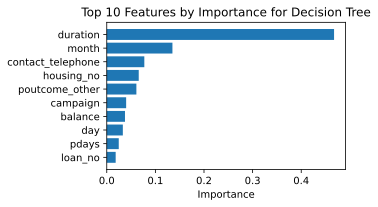

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sorted_features = sorted(zip(features_list, importances), key=lambda x: x[1], reverse=True)

top_features = [feature for feature, importance in sorted_features[:10]]
top_importances = [importance for feature, importance in sorted_features[:10]]

# bar chart
plt.figure(figsize=(5,3))
plt.barh(top_features, top_importances, align='center')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance for Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()